<a href="https://colab.research.google.com/github/eugenie-kim012/Daily-Log/blob/main/D%2B44_Finance_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 환경 구성, 데이터 가져오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

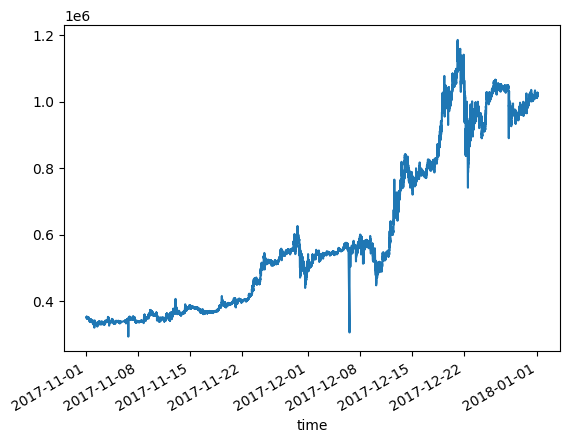

In [2]:
# 이 데이터는 17년 11월 12월 2달간의 변화 close는 종가
DATA_PATH = '.'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

<Axes: xlabel='time'>

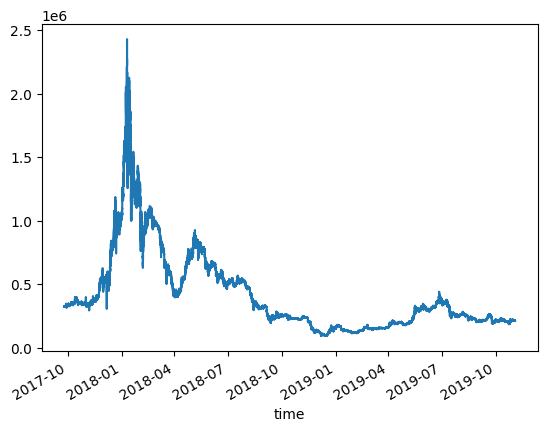

In [3]:
# 전체 데이터는 19년도까지있다
modify_data['close'].plot()

# 2. Technical Index
## 2.1. 추세, 거래량, 변동성, 모멘텀 (+ 활용하고자 하는 시점에 수익률, 변화율, 변동성 적용)

### 2.1.1. Data Labeling

* Price Change Direction
* Using Moving Average
* Local Min-Max
* Trend Scanning

#### 2.1.1.1. Price Change Direction


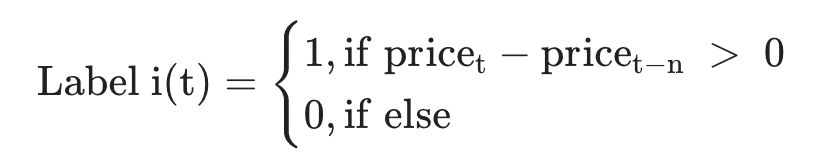

In [4]:
window = 10  # 모멘텀을 계산할 이동 기간 설정 (예: 10일)

# 두 번 np.sign을 사용하는 트릭을 통해 단순화된 모멘텀 시그널 계산
# - modify_data['close'] - modify_data['close'].shift(window): window일 전과의 가격 차이 계산
#modify_data['close']; closing price, 종가
# .shift(window): window일(예: 10일) 전의 종가로 이동
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
# - np.sign(...): 가격 차이가 양수면 1, 음수면 -1, 같으면 0
# - np.sign(... + 1): 결과를 다시 sign 처리해 [-1, 0, 1] → [0, 1, 1] 로 변환

# 계산된 시그널을 pandas Series로 변환하여 원래 데이터의 인덱스와 정렬
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

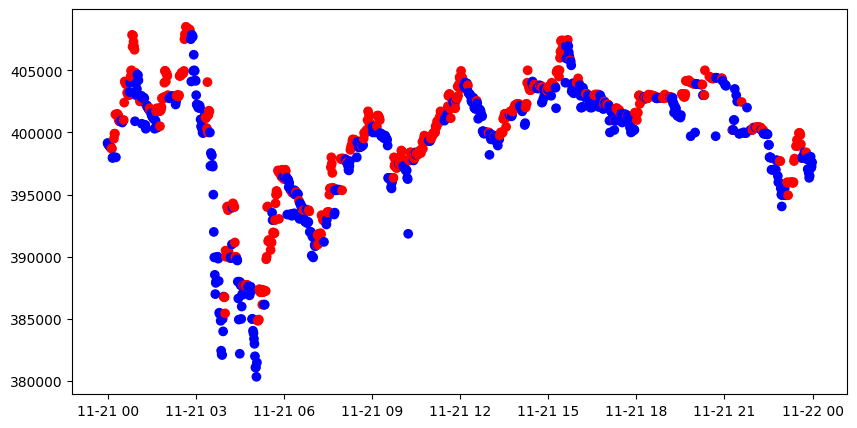

In [5]:
# 특정 날짜('2017-11-21')의 종가(close price)만 선택하여 sub_data에 저장
sub_data = modify_data.loc['2017-11-21', 'close']

# 동일한 날짜의 모멘텀 시그널 값을 가져옴 (0 또는 1의 시리즈)
c_sig = s_momentum_signal.loc['2017-11-21']

# 시그널 값이 1이면 'red', 0이면 'blue'로 색상 배열 생성
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 그래프 사이즈 설정
plt.figure(figsize=(10,5))

# 산점도 그리기:
# - x축: sub_data의 인덱스 (시간)
# - y축: 종가 값
# - 점 색깔: 모멘텀 시그널에 따라 정해진 색상
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])


In [6]:
s_momentum_signal.head(15)

,close
time,
2017-09-25 03:00:00,NaN
2017-09-25 03:01:00,NaN
2017-09-25 03:02:00,NaN
2017-09-25 03:05:00,NaN
2017-09-25 03:06:00,NaN
2017-09-25 03:07:00,NaN
2017-09-25 03:10:00,NaN
2017-09-25 03:11:00,NaN
2017-09-25 03:12:00,NaN


#### 2.1.1.2. Using Moving Average


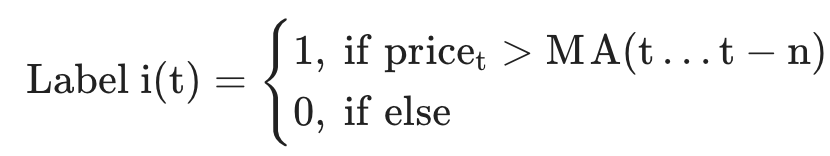

In [7]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

# # ✅ 현재 종가가 이동평균보다 높은지 여부를 이용한 모멘텀 시그널 생성
# momentum_signal = np.sign(                             # 결과를 0 또는 1로 단순화
#     np.sign(                                           # 가격과 이동평균의 차이를 부호로 변환
#         modify_data['close'] -                        # 현재 종가에서
#         modify_data['close'].rolling(window).mean()   # window 기간 이동평균을 뺀다
#     ) + 1                                              # -1 → 0, 0 → 1, 1 → 2로 변환
# )

# # ✅ 위에서 구한 시그널 값을 시계열 인덱스를 기준으로 Series로 저장
# s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)
# modify_data['close'].rolling(window).mean()
# → 특정 기간(window) 동안의 이동 평균선(Moving Average) 을 계산합니다.

# modify_data['close'] - ...
# → 현재 종가가 이동 평균보다 높은지를 계산합니다.

# np.sign(...)
# → 종가 > 이동평균 → 1
# 종가 < 이동평균 → -1
# 동일 → 0

# np.sign(...) + 1
# → -1 → 0, 0 → 1, 1 → 2

# 바깥쪽 np.sign(...)
# → 0 → 0, 1 → 1, 2 → 1

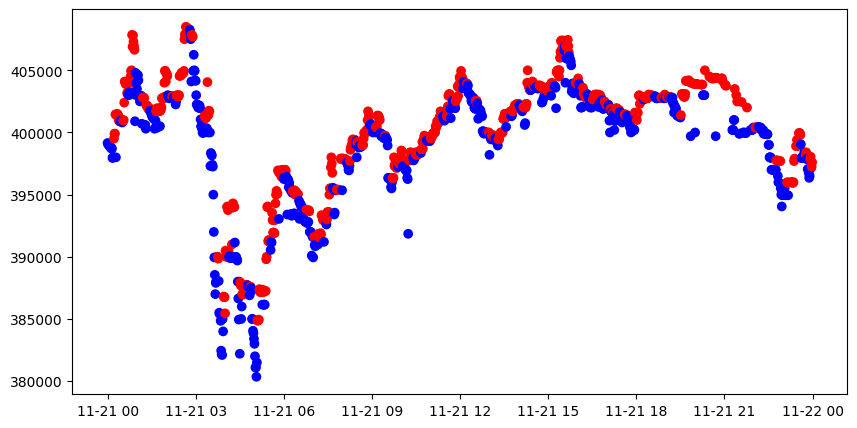

In [8]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [9]:
s_momentum_signal.head(15)

,close
time,
2017-09-25 03:00:00,NaN
2017-09-25 03:01:00,NaN
2017-09-25 03:02:00,NaN
2017-09-25 03:05:00,NaN
2017-09-25 03:06:00,NaN
2017-09-25 03:07:00,NaN
2017-09-25 03:10:00,NaN
2017-09-25 03:11:00,NaN
2017-09-25 03:12:00,NaN


#### 2.1.1.3. Local Min-Max

* Local Min/Max의 경유 알고리즘에 따라 결과값이 다름


```
[Pseudo-code]
𝐼𝑛𝑖𝑡𝑖𝑎𝑙𝑖𝑧𝑒 𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠𝑓𝑜𝑟 𝑖 𝑖𝑛 𝑑𝑎𝑡𝑎𝑠𝑒𝑡:
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒<𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒>𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
```


In [10]:
# Local min / max 를 추출하기 위한 함수
# 이 함수는 주가가 일정 기간 동안 오르거나 내리지 않으면 → 국지적 최고/최저로 인식하고 기록.
# wait=3이면 3일 연속 반전 없이 유지된 저점/고점만 유효한 신호로 간주.
# 노이즈를 줄이면서 신뢰도 높은 고점/저점 탐지.


def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

# close: 시계열 형태의 종가 데이터 (pd.Series)
# wait: 새로운 고점/저점을 인식하기 전에 기다릴 최소 기간 (지속성 필터 역할)

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

# min_value, max_value: 현재까지 찾은 최저/최고 값
# n_cnt_min, n_cnt_max: 최저/최고값이 유지된 기간 (몇 번 연속 유지됐는지)
# mins, maxes: 발견된 국지적 최소/최대값 목록
# min_idxes, max_idxes: 해당 값의 인덱스(시점)
# b_min_update, b_max_update: 이번 루프에서 새로 최소/최대가 갱신되었는지 여부

    for idx, val in zip(close.index[1:], close.values[1:]): #첫 번째 값은 초기값으로 사용했기 때문에 루프는 1번째 인덱스부터 시작.
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True

# 이전보다 더 낮은 값이 나타나면 로컬 최소값으로 간주하고 기록.
# 카운터(n_cnt_min)를 0으로 초기화, 새로 업데이트 플래그 설정.

        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

# 이전보다 더 높은 값이 나타나면 로컬 최대값으로 간주하고 기록.
# 카운터(n_cnt_max) 초기화, 새로 업데이트 플래그 설정.

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

# 일정 기간(max가 갱신되지 않는다면), min_value를 max_value로 강제 초기화 (추세 반전 탐지)
# 일정 기간(min이 갱신되지 않는다면), max_value를 min_value로 강제 초기화

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

# # 두 개의 DataFrame 반환:
# 하나는 로컬 최소값 시점과 값들
# 하나는 로컬 최대값 시점과 값들

In [11]:
mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

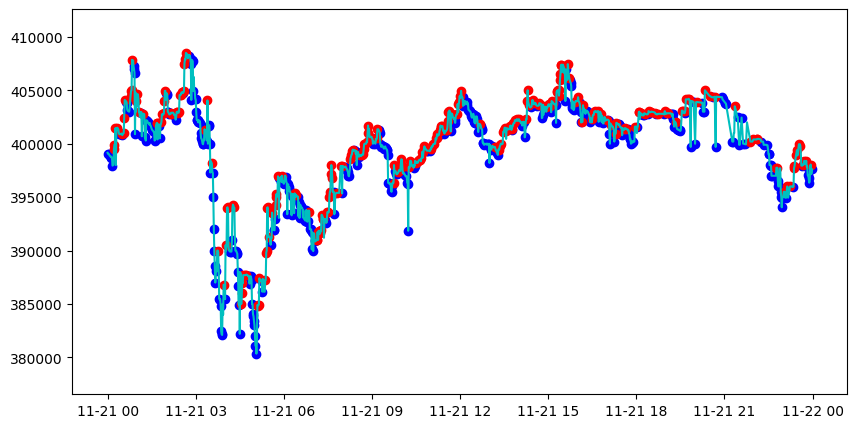

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01]) ## ✅ y축 범위를 원본 데이터보다 약간 여유 있게 설정 (±1% 여유)

(376546.5, 412585.0)

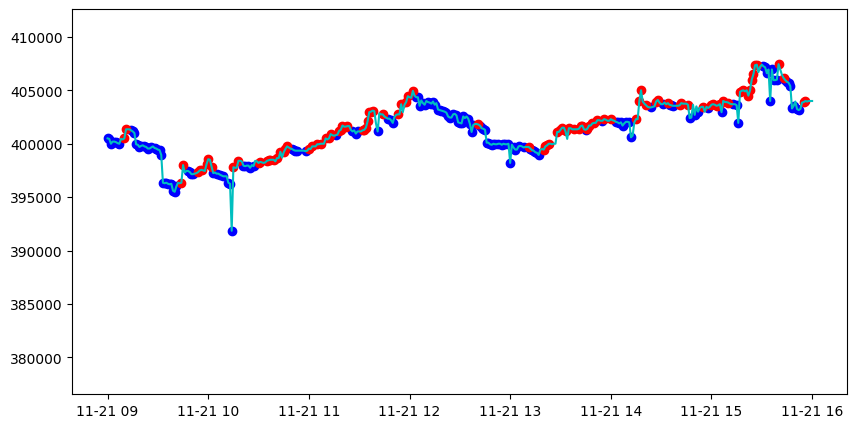

In [13]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

# 특정 시간 범위 설정 (분 단위까지 포함한 시계열 필터)
# 전체 데이터가 아니라, 특정 시간 범위 (09:00 ~ 16:00)만 그려짐
# mins에 있는 최소값들 중 시간 조건에 부합하는 데이터만 추출해서 시각화
# drop=False는 인덱스로 설정하더라도 원래의 컬럼을 유지하게 함 (그래프용 x축에서 사용 가능)



# 첫 번째 버전: sub_data의 전체 구간에서 모든 국지적 극값을 보여줌 → 전체 추세 시각화에 적합
# 두 번째 버전: 특정 시간 범위(09:00 ~ 16:00)에 한정하여 극값 시각화 → 시간대별 분석에 적합

In [14]:
mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


#### 2.1.1.4. Trend Scanning

https://github.com/hudson-and-thames/mlfinlab

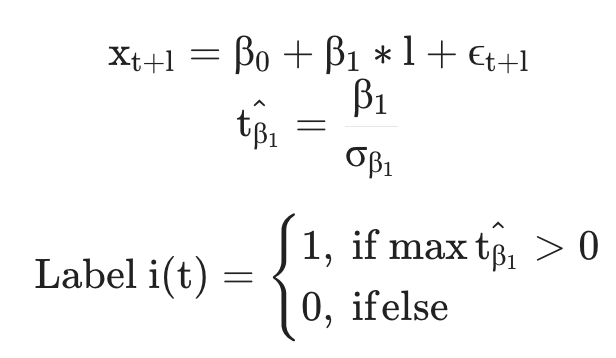

In [15]:
## 책에 없는 코드 라벨링까지 마무리 하는 코드를 짜봅시다

# 1. 극소/극대 포인트 합치기
extrema_df = pd.concat([
    mins.rename(columns={'min_time': 'time', 'local_min': 'value'}).assign(type='min'),
    maxes.rename(columns={'max_time': 'time', 'local_max': 'value'}).assign(type='max')
])

# mins, maxes 두 DataFrame을 concat()으로 합칩니다.
# 공통된 구조로 맞추기 위해 컬럼명을 time, value로 통일:
# 'min_time' → 'time', 'local_min' → 'value'
# 'max_time' → 'time', 'local_max' → 'value'
# type='min', type='max' 으로 구분용 컬럼 추가
# 📌 결과: 극값 포인트들이 하나의 표로 합쳐짐

# 2. 시간 순으로 정렬
extrema_df = extrema_df.sort_values(by='time').reset_index(drop=True)
# reset_index(drop=True)는 원래 인덱스를 버리고 새로 매김

# 3. 각 구간의 변화 방향 라벨링
trend_labels = []
for i in range(len(extrema_df) - 1):
    current_val = extrema_df.loc[i, 'value']
    next_val = extrema_df.loc[i+1, 'value']
    label = 1 if next_val > current_val else 0
    trend_labels.append(label)

# 두 극값 사이의 값의 증감 여부를 확인해서 라벨을 만듭니다:
# 1: 다음 점이 현재보다 큼 → 상승 추세
# 0: 다음 점이 현재보다 작거나 같음 → 하락 또는 유지
# 마지막 점은 비교 대상이 없기 때문에 아래처럼 따로 처리

# 마지막 포인트는 라벨 없음 → NaN 또는 0 처리
trend_labels.append(0)

# 4. 최종 결과
extrema_df['label'] = trend_labels
print(extrema_df.head(15))

                  time   value type  label
0  2017-11-21 00:01:00  399050  min      0
1  2017-11-21 00:03:00  399000  min      0
2  2017-11-21 00:04:00  398900  min      0
3  2017-11-21 00:05:00  398850  min      0
4  2017-11-21 00:06:00  398800  min      0
5  2017-11-21 00:07:00  398800  min      0
6  2017-11-21 00:08:00  398700  min      0
7  2017-11-21 00:10:00  397950  min      1
8  2017-11-21 00:13:00  399500  max      1
9  2017-11-21 00:14:00  399900  max      1
10 2017-11-21 00:16:00  401450  max      0
11 2017-11-21 00:19:00  401350  max      1
12 2017-11-21 00:20:00  401500  max      0
13 2017-11-21 00:23:00  401000  min      0
14 2017-11-21 00:24:00  400900  min      0


In [16]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

# x는 (n, 2) 행렬: 첫 번째 열은 모두 1 (절편), 두 번째 열은 일단 1로 채움
# 회귀 분석에서 절편(intercept)을 포함시키기 위해 필요
# 두 번째 열을 0, 1, 2, ..., n-1 로 채움 → 즉, 시간(순서)을 나타냄
# 시간 순서가 독립 변수 역할
# close (종가 시계열) 값을 종속 변수로 놓고 선형 회귀 수행
# x는 절편 + 시간 추세의 독립 변수 역할
# ols.tvalues[1]는 시간 추세에 대한 t-통계량입니다.
# 이 값이 클수록 (절대값 기준) 시간이 지남에 따라 값이 유의미하게 오르거나 내림을 의미합니다.

In [17]:
# 슬라이딩 윈도우 설정
look_forward_window = 60       # 추세를 분석할 구간 길이
min_sample_length = 5          # 회귀 분석에 필요한 최소 데이터 수
step = 1                       # 윈도우를 얼마나 건너뛸지
t1_array = []                  # 분석 시작 시점(또는 예측 기준 시점) 저장
t_values_array = []            # 각 구간의 t-value 저장

이 t-value로 뭘 할 수 있나요?
추세(trend)가 통계적으로 유의한지 판단할 수 있어요.
일반적인 기준:

|t| > 2 → 유의미한 추세가 존재한다고 판단 가능 (신뢰수준 약 95%)

예시 활용:

가격이 상승 추세인지 또는 하락 추세인지 확인
변동성 필터링 또는 트렌드 기반 진입 조건 만들 때

In [18]:
# ⚠️ 이 코드는 20~30분 이상 실행 시간이 걸릴 수 있습니다

# 분석 대상 시점: 2017년 11월 한 달간의 데이터 인덱스
molecule = modify_data['2017-11-01':'2017-11-30'].index

# 결과 저장을 위한 빈 DataFrame 생성
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])

# 결과를 누적할 리스트
tmp_out = []

# 각 시점(ind) 기준으로 전방 60개 데이터 추세 분석
for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 현재 시점부터 60개 데이터 추출
    if look_forward_window > subset.shape[0]:  # 데이터가 부족하면 건너뜀
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])  # t-value를 저장할 인덱스 준비
    tval = []

    # 구간 길이를 점점 늘리며 회귀분석(t-value 계산)
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # 선형 회귀 후 t-value 추출

    tmp_subset.loc[tmp_subset.index] = np.array(tval)  # 계산한 t-value 저장

    # 가장 강한 추세가 나타난 시점 찾기 (절댓값이 가장 큰 t-value)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]

    # [t1: 분석 대상 끝 시점, t_val: 추세 강도, bin: 추세 방향] 저장
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

# 최종 결과를 label DataFrame에 저장
label.loc[molecule] = np.array(tmp_out)  # 데이터 누수 방지

# 형 변환 및 정리
label['t1'] = pd.to_datetime(label['t1'])  # 문자열 → datetime
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')  # 메모리 절약용 정수화


100%|██████████| 33384/33384 [16:01<00:00, 34.73it/s]


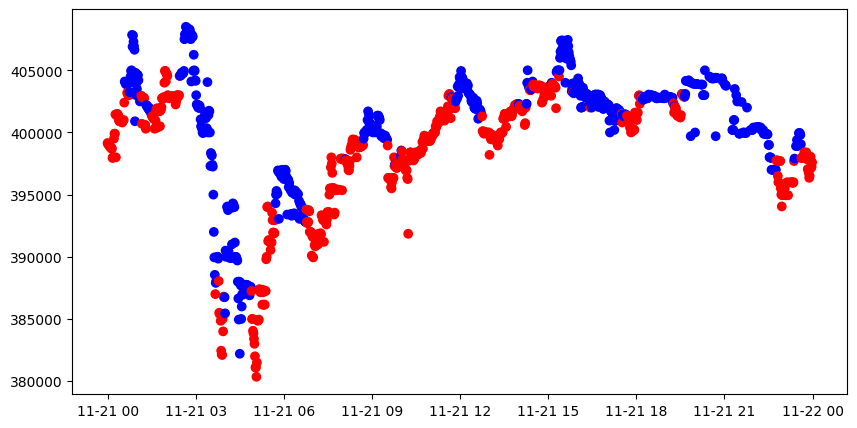

In [19]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

In [20]:
label.head(20)

,t1,t_val,bin
time,,,
2017-11-01 00:05:00,2017-11-01 06:10:00,-6.373987,-1
2017-11-01 00:12:00,2017-11-01 06:16:00,-6.273936,-1
2017-11-01 00:18:00,2017-11-01 06:23:00,-5.897474,-1
2017-11-01 00:24:00,2017-11-01 06:29:00,-5.425023,-1
2017-11-01 00:31:00,2017-11-01 06:35:00,-5.08177,-1
2017-11-01 00:37:00,2017-11-01 06:42:00,-4.895976,-1
2017-11-01 00:43:00,2017-11-01 06:48:00,-5.11334,-1
2017-11-01 00:50:00,2017-11-01 06:54:00,-4.866885,-1
2017-11-01 00:56:00,2017-11-01 07:00:00,-3.673143,-1


# 3. Feature Engineering
## 3.1. 환경 구성 (ta, shap), 데이터 가져오기

* shap - Python Pandas 기반의 금융 시계열 데이터 분석을 지원하는 라이브러리, https://libraries.io/pypi/ta

In [21]:
!pip install ta==0.9.0
!pip install shap

In [22]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
import sys
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

## 3.2. Wrapper Method 함수 만들기
* "Advanced in Financial AI",

In [23]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

## 3.3. 데이터 가져오기
* Feature Engineering 할 데이터 가져오기
*  Pickle(.pkl)은 Python의 list, class, dictionary와 같은 자료형(type)을 바이너리로 변환하여 파일로 저장된 것

In [24]:
DATA_PATH = '.'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

In [25]:
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [26]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [27]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [28]:
df_label_data.value_counts()

,count
t_value,
-1.0,306636
-0.0,302963
1.0,299289


In [29]:
df_label_data.value_counts()

,count
t_value,
-1.0,306636
-0.0,302963
1.0,299289


## 3.4. Technical Index
### 3.4.1. 기술적 지표

In [30]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [31]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


### 3.4.2. 수익률 / 변동성 지표

In [32]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [33]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [34]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [35]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


In [36]:
X_sc.shape

(957, 23)

In [37]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## 3.5. Feature Selection methods
### 3.5.1. MDI, Mean Decrease Impurity


In [38]:
# LMS와 다르게 우리는 함수를 직접 호출해줘서 imp. 을 지웠습니다
# feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp = mean_decrease_impurity(rfc, X.columns)

In [39]:
feat_imp

,mean,std
volume_cmf,0.046311,0.002474
volume_fi,0.046368,0.002517
volume_mfi,0.048164,0.002516
volume_sma_em,0.039834,0.001894
volume_vpt,0.025887,0.001663
volatility_atr,0.073462,0.003291
volatility_ui,0.047519,0.002522
trend_macd_diff,0.080412,0.003744
trend_adx,0.054809,0.002180
trend_trix,0.066889,0.003240


### 3.5.2. MDA, Mean Decrease Accuracy



In [40]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [41]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

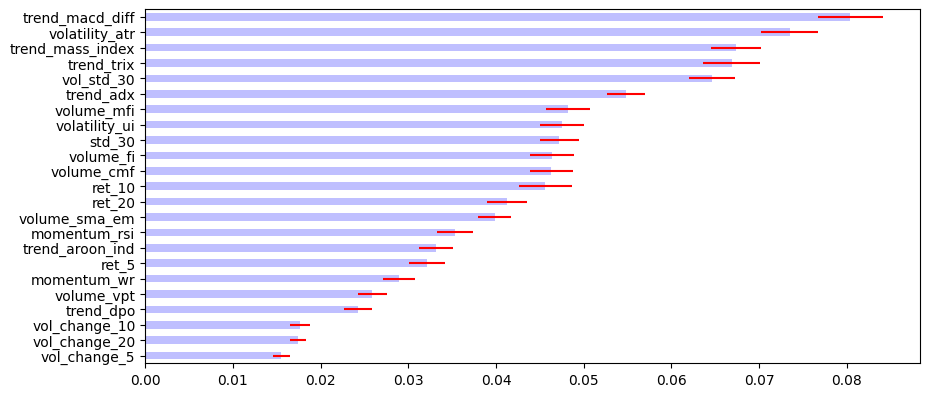

In [42]:
# volatility_atr : 시장의 변동성(진폭)을 측정하는 지표입니다
# Average True Range (ATR)
plot_feature_importance(feat_imp)

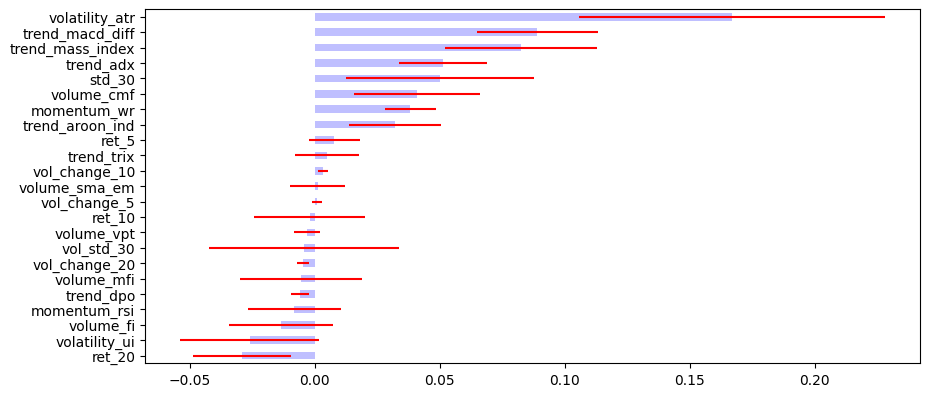

In [43]:
plot_feature_importance(feat_imp_mda)

## 3.6. Sequential Feature Selection
### 3.6.1. RFE CV, Recursive Feature Elimination

In [44]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [45]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [46]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


### 3.6.2. SFS, Sequential Feature Selection


In [47]:
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [48]:
sfs_rank = sfs_fitted.get_support()

# 최신 버전은 {} 대신 []를 사용해야함
#sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

### 3.6.3. SHAP, Shapley Additive explanations

In [49]:
# !pip install --upgrade typing_extensions
# -> LMS에서 오류가남 버전 재설치를 해야한다
import shap
# 모델 output을 raw로 바꿔주기
explainer = shap.TreeExplainer(rfc, model_output="raw")
shap_value = explainer.shap_values(X_sc)

In [50]:
shap_value.shape

(957, 23, 3)

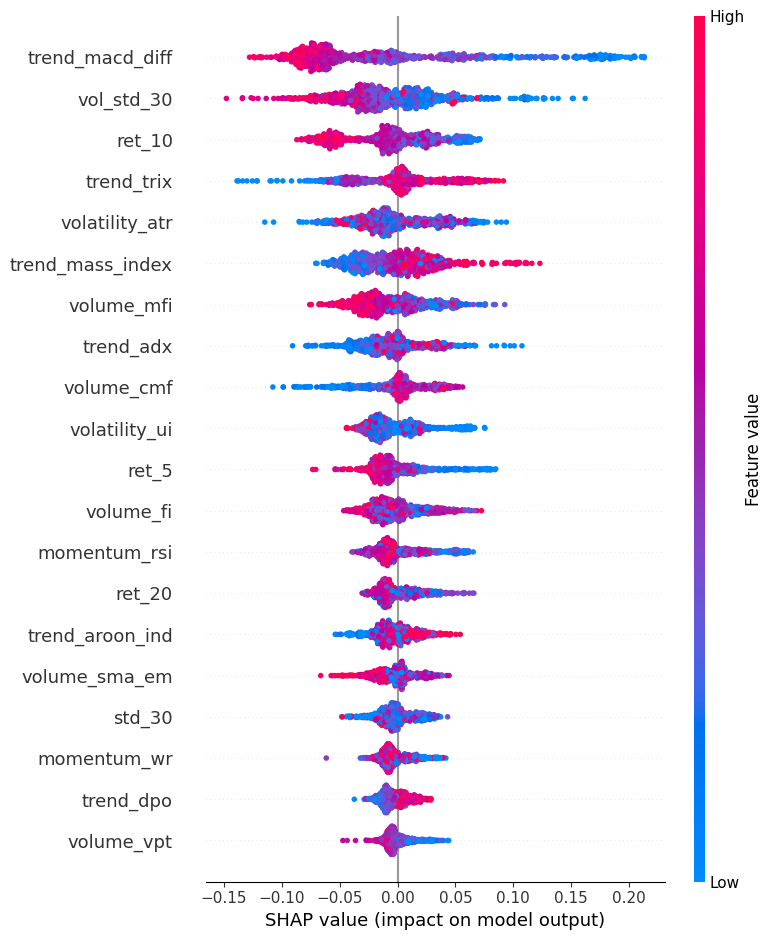

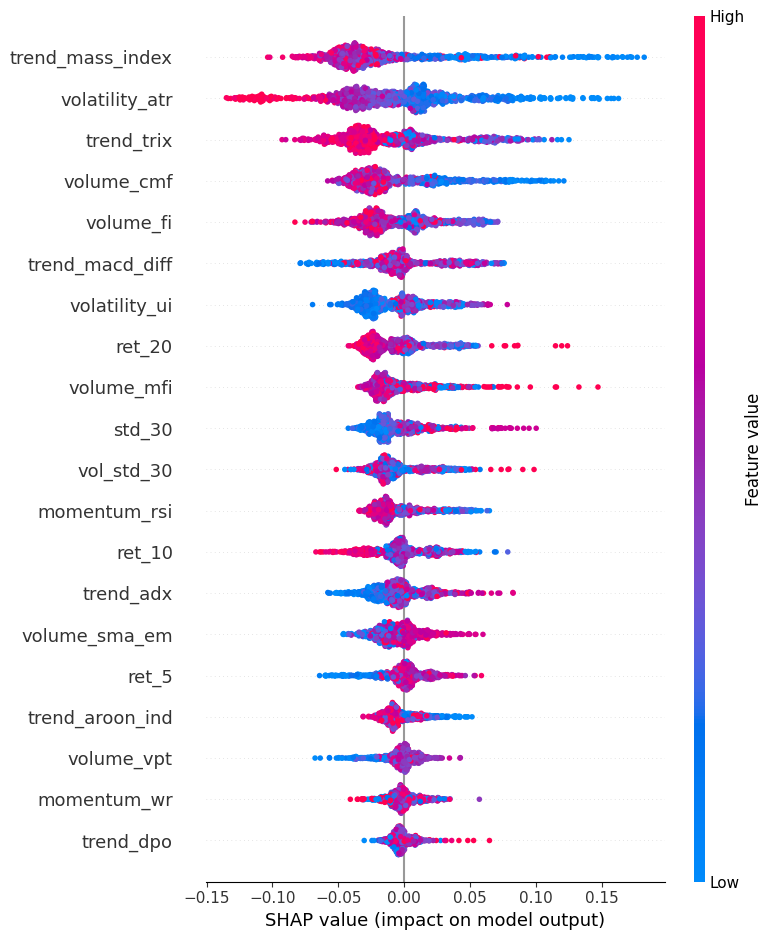

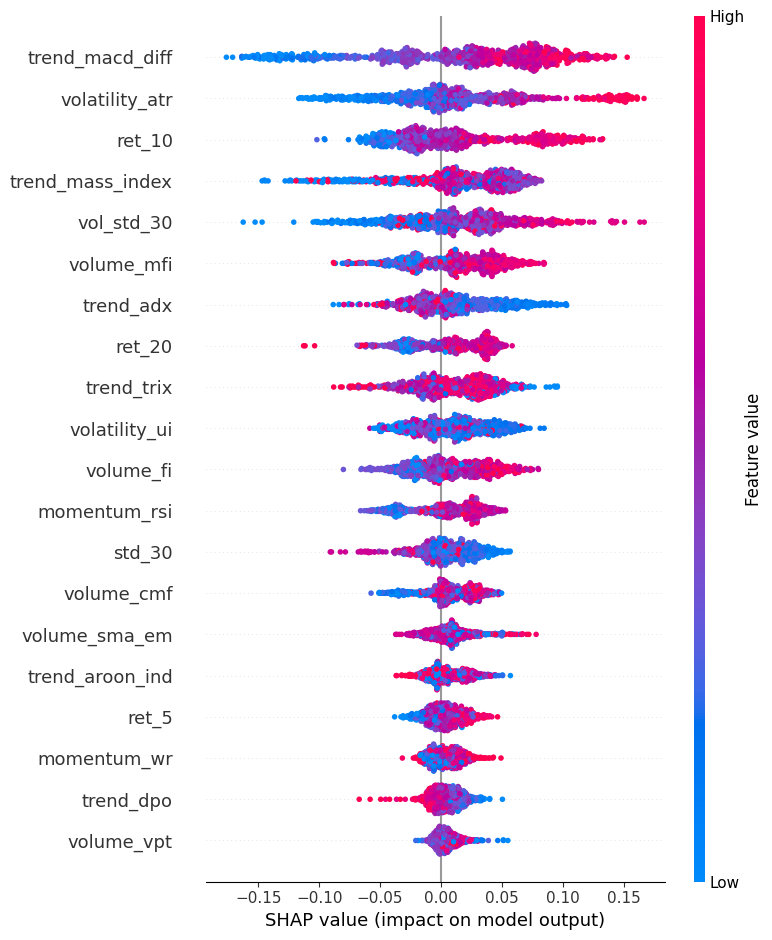

In [51]:
# 각 클래스에 대한 각각의 plot을 그려줘야함

# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

In [52]:
# 절댓값 평균으로 전체 feature 중요도 요약
mean_shap = np.mean(np.abs(shap_value), axis=(0, 2))  # over samples and classes
shap_df = pd.Series(mean_shap, index=X_sc.columns).sort_values(ascending=False)
print(shap_df)

trend_macd_diff     0.050724
volatility_atr      0.036466
trend_mass_index    0.035170
vol_std_30          0.029348
trend_trix          0.028385
ret_10              0.027756
volume_mfi          0.023680
volume_cmf          0.021564
volume_fi           0.021497
volatility_ui       0.021480
trend_adx           0.020761
ret_20              0.019854
momentum_rsi        0.018599
std_30              0.015320
ret_5               0.013028
volume_sma_em       0.012725
trend_aroon_ind     0.012288
momentum_wr         0.009530
trend_dpo           0.008441
volume_vpt          0.007865
vol_change_10       0.003832
vol_change_20       0.003617
vol_change_5        0.003335
dtype: float64


In [53]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

# 4. Model Training
## 4.1. 환경구성


In [54]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.mlutil.pkfold import PKFold

## 4.2. Purged K-fold validation 함수 만들기

In [55]:
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

## 4.3. 데이터 가져오기

In [56]:
DATA_PATH = '.'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

In [57]:
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [58]:
df_data['t_value'].value_counts()

,count
t_value,
1.0,481
0.0,476


In [59]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [60]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [61]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

## 4.4  Find the best param for bagging(RandomForest) with grid-search

In [62]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

In [63]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
# 파라미터 명을 변경해야합니다
# 'base_estimator__max_depth': [3,5,10,20],
# base 모조리 빼버리기

bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [64]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=20,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7)

In [65]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [66]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[83 53]
 [12 43]]
정확도:0.6596858638743456, 정밀도:0.4479166666666667, 재현율:0.7818181818181819


auc:0.6960561497326203


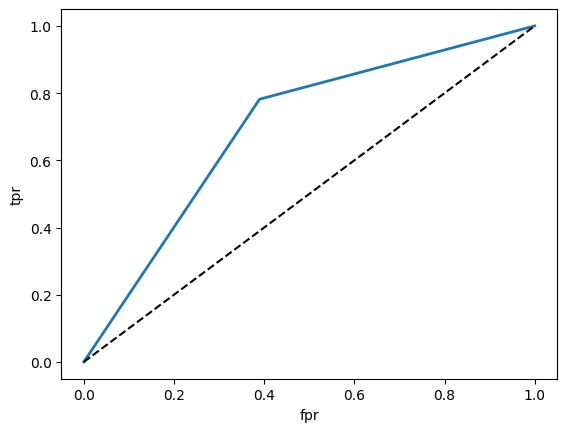

In [67]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')